# Navigation

---


## 1. Start the Environment

We begin by importing some necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import logging
logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
logger = logging.getLogger()
logger.setLevel(logging.DEBUG)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/VisualBanana.app"`
- **Windows** (x86): `"path/to/VisualBanana_Windows_x86/Banana.exe"`
- **Windows** (x86_64): `"path/to/VisualBanana_Windows_x86_64/Banana.exe"`
- **Linux** (x86): `"path/to/VisualBanana_Linux/Banana.x86"`
- **Linux** (x86_64): `"path/to/VisualBanana_Linux/Banana.x86_64"`
- **Linux** (x86, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86"`
- **Linux** (x86_64, headless): `"path/to/VisualBanana_Linux_NoVis/Banana.x86_64"`

For instance, if you are using a Mac, then you downloaded `VisualBanana.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="VisualBanana.app")
```

In [2]:
env = UnityEnvironment(file_name="Banana.app")

DEBUG:unityagents:The true file name is Banana
DEBUG:unityagents:This is the launch string /Users/ddahlem/githubs/deep-reinforcement-learning-navigation/Banana.app/Contents/MacOS/mac_banana
INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

## 2. Examine the State and Action Spaces

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents in the environment
print('Number of agents:', len(env_info.agents))

# number of actions
action_size = brain.vector_action_space_size
print('Number of actions:', action_size)

# examine the state space 
state = env_info.vector_observations[0]
print('States look like:', state)
state_size = len(state)
print('States have length:', state_size)

Number of agents: 1
Number of actions: 4
States look like: [1.         0.         0.         0.         0.84408134 0.
 0.         1.         0.         0.0748472  0.         1.
 0.         0.         0.25755    1.         0.         0.
 0.         0.74177343 0.         1.         0.         0.
 0.25854847 0.         0.         1.         0.         0.09355672
 0.         1.         0.         0.         0.31969345 0.
 0.        ]
States have length: 37


## 3. Deep Reinforcement Learning!

In order to train your own agent to solve the environment we take few **important notes**:
- When training the environment, set `train_mode=True`, so that the line for resetting the environment looks like the following:
```python
env_info = env.reset(train_mode=True)[brain_name]
```
- In this coding environment, you will not be able to watch the agent while it is training.  However, **_after training the agent_**, you can download the saved model weights to watch the agent on your own machine!

### 3.1 Training Loop

The following `train` function encapsulates the training loop. It accepts an `agent` and a dictionary of parameters for the individual components, including replay buffer, policy, and agent.

The dictionary of parameters take the following form:
```python
params = {
    'name': 'DDQN',              # name of the experiment
    'episodes': 2000,            # number of episodes
    'max_t': 1000,               # maximum length of an episode
    'policy': EpsilonGreedy,
    'policy_params': {
        'eps_start': 1.0,            # starting value for the epsilon-greedy action selection
        'eps_end': 0.01,             # end value for the epsilon-greedy action selection
        'eps_decay': 0.995           # decay rate for the epsilon-greedy action selection
    },
    'agent_params': {
        'alpha': 0.4,                # alpha power value for the prioritized replay buffer sampling
        'gamma': 0.99,               # discount factor
        'tau': 0.001,                # mixing rate soft-update of target parameters
        'lr': 0.0005,                # learning rate
        'update_every': 4,           # update every n-th step
        'network_type': QNetwork,    # network architecture
        'network_params': {
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': 6453,                # seed of the network architecture
            'hidden_layers': [64, 32],   # hidden layer neurons
            'dropout': 0.05
        },
        'experience_params': {
            'seed': 184,                 # seed for the experience replay buffer
            'buffer_size': 1000,         # size of the replay buffer
            'batch_size': 64             # batch size sampled from the replay buffer
        },
    },
    'maxlen': 100,               # sliding window size of recent scores
    'beta_start': 0.4,           # starting value for the beta value of prioritized replay sampling
    'brain_name': brain_name     # the brain name of the unity environment
}
```

The dictionary of parameters introduces scoping of the configuration parameters with respect to the component being configured. One consideration is to afford each component its own random number seed to avoid spurious correlation introduced by a single shared seed.

In [5]:
from rl.value.train import train

### 3.2 Replay Buffer

There are two replay buffer implementations, `UniformExperienceBuffer` and `PrioritizedExperienceBuffer`. Both inherit from an abstract base class `ReplayBuffer` that declares the abstract methods:
 - `add()`: add an experience to the buffer of a fixed and confirgurable size
 - `sample()`: sample from the buffer
 - `ready()`: check whether the batch size is smaller than the current buffer size
 
The `UniformExperienceBuffer` implements a uniform sampling strategy that makes no distinction between the individual experiences, while the `PrioritizedExperienceBuffer` implements the strategy set out in the original paper by [Schaul et al.](https://arxiv.org/abs/1511.05952). The experiences are replayed according to the magnitude of the temporal difference error, thus given the agent the opportunity to learn from more meaningful transitions.

The probabilities of sampling from the experience buffer are defined as:

$$P(i) = \frac{p_i^\alpha}{\sum_k p_k^\alpha}$$

where $p_i$ is the prioritisation of the $i$-th experience and $alpha \in [0; 1]$ is a smoothing parameter. If $alpha$ is equal to zero than this conforms to the uniform sampling strategy and the closer to 1 the stronger the weight towards to the true probabilities.

The priorities, $p_i$, are computed as the magnitude of the TD error plus an additional small positive number for numeric stability in case the error is very close to zero, i.e., $p_i=|\delta_i| + \epsilon$.

We further need to introduce importance-sampling weights, because of the associated bias in the prioritized experience replay:

$$w_i = (\frac{1}{N} * \frac{1}{P(i)})^\beta$$

where $\beta$ is annealed to 1 towards the end of training. This parameter interacts with the $\alpha$ value in that sampling more aggressively ($\alpha = 1$) is corrected more strongly in the IS weights ($\beta = 1$). The weights, $w_i$, are also scaled by $\frac{1}{\max(w)}$.

### 3.3 Double Q-Networks

As for the deep reinforcement algorithms, this solution uses two approaches. The first one is based on double deep Q-network function approximators in reinforcement learning settings, which has been found to address the general problem of value overestimation in traditional DQN architectures [Hasselt, Guez, Silver](https://arxiv.org/abs/1509.06461). This is accomplished by decoupling the determination of the greedy policy from the evaluation of its target value. The solution works as follows:

- Use the DQN, with the online weights $\theta$, to compute the greedy action given the next state
- Use the target DQN, with weights $\theta^{\prime}$, to compute the value of taking that action in the next state

$$Q(s, a, \theta^{\prime}) = r(s, a) + \gamma * Q(s^{\prime}, argmax_{a^{\prime}} Q(s^{\prime}, a^{\prime}, \theta), \theta^{\prime})$$

At the end of the learning process, we can then perform a soft-update to switch the weights:

$$\theta^{\prime} = \tau * \theta + (1 - \tau) * \theta^{\prime}$$

where $\tau$ is a mixing factor of the two weight vectors eminating from the online and target network respectively.

For the DQN, the following architecture is implemented:

```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1                [-1, 1, 128]          4,736
           Dropout-2                [-1, 1, 128]              0
            Linear-3                [-1, 1, 64]           8,192
           Dropout-4                [-1, 1, 64]               0
            Linear-5                 [-1, 1, 4]             256
================================================================
Total params: 13,184
Trainable params: 13,184
Non-trainable params: 0
----------------------------------------------------------------
```

### 3.4 Dueling Double Q-Network

The underlying mechanism of Dueling Double Q-Networks (DDQN) rely on the decomposition of Q-value function into [Wang et al.](https://arxiv.org/abs/1511.06581):

$$Q(s, a) = A(s, a) + V(s)$$

where 

- $A(s, a)$ is an advantage function of an action $a$ in state $s$
- $V(s)$ is the value-function given state $s$.

Decomposing the Q-value function this way has the advantage of being able to learn the value of a state without having to also include the effect of the actions given the states. This is useful when the action values do not need to be computed. However, the ability to decompose $Q(s, a)$ this way does imply that for every unique Q-value we have unique advantage and value functions respectively. To address this, we subtract the mean of the advantage function over all actions from the chosen action:

$$Q(s, a, \theta, \alpha, \beta) = V(s, \theta, \alpha) + A(s, a, \theta, \beta) - \frac{1}{B}\sum_{a^{\prime}}A(s, a^{\prime}, \theta, \beta)$$

The DDQN architecture is also fixed as follows:

```
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
================================================================
            Linear-1                [-1, 1, 128]           4,736
           Dropout-2                [-1, 1, 128]               0
            Linear-2                [-1, 1, 64]            8,192
           Dropout-3                [-1, 1, 64]                0
      Value-Linear-4.1              [-1, 1, 512]          32,768
     Value-Dropout-5.1              [-1, 1, 512]               0
      Value-Linear-6.1              [-1, 1, 1]               512
     Value-Dropout-7.1              [-1, 1, 1]                 0
  Advantage-Linear-4.2              [-1, 1, 512]          32,768
 Advantage-Dropout-5.2              [-1, 1, 512]               0
  Advantage-Linear-6.2              [-1, 1, 4]             2,048
 Advantage-Dropout-7.2              [-1, 1, 4]                 0
================================================================
Total params: 81,024
Trainable params: 81,024
Non-trainable params: 0
----------------------------------------------------------------
```

Both, the value and advantage fully connected layers, $\alpha$ and $\beta$ respectively, are separate streams off the first shared fully connected layers, $\theta$, (all with ReLU activation and dropout).

## 4. Value-based Methods and Experiments
This section covers 4 experiments without hyperparameter tuning. The two combinations of experience replay and network architectures are pitted against each other.

Before moving into the experiments, I'd like to highlight some of the dynamic parameters of this implementation, namely the epsilon-greedy policy ($\epsilon$) and those involved in the prioritized replay ($\alpha$ and $\beta$) respectively. We fixed $\alpha=0.4$. The other two parameters are scheduled along the episode number.

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:rl.value.policy:Parameter: {'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.9975}


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.font_manager:findfont: Matching :family=sans-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0 to DejaVu Sans ('/Users/ddahlem/anaconda3/envs/drlnd/lib/python3.6/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSans.ttf') with score of 0.050000.
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


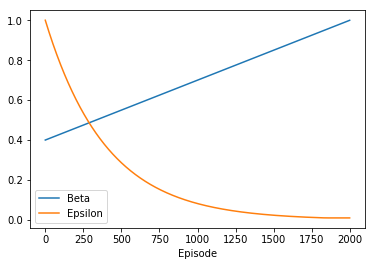

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from rl.utils.policy import EpsilonGreedy

params = {
    'episodes': 2000,            # number of episodes
    'policy': EpsilonGreedy,
    'policy_params': {
        'eps_start': 1.0,            # starting value for the epsilon-greedy action selection
        'eps_end': 0.01,             # end value for the epsilon-greedy action selection
        'eps_decay': 0.9975           # decay rate for the epsilon-greedy action selection
    },
    'beta_start': 0.4            # starting value for the beta value of prioritized replay sampling
}

n_episodes = params['episodes']
beta_start = params['beta_start']
policy = params['policy'](params['policy_params'])

beta_schedule = lambda episode: min(1.0, beta_start + episode * (1.0 - beta_start) / n_episodes)

df = pd.DataFrame([])

for e in np.arange(n_episodes):
    df = df.append(pd.DataFrame({'Episode': e, 'Beta': beta_schedule(e), 'Epsilon': policy.eps}, index=[0]), ignore_index=True)
    policy.decay()

df.plot(x='Episode', y=['Beta', 'Epsilon'], kind='line')

### 4.1 DQN Agent with Uniform Experience Replay

This experiment configures a Double Q-Network Agent with uniform experience replay.

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from rl.value.agent import DDQN_UER_Agent
from rl.value.model import QNetwork
from rl.utils.policy import EpsilonGreedy

params = {
    'name': 'DDQN_UER',
    'episodes': 2000,            # number of episodes
    'max_t': 5000,               # maximum length of an episode
    'policy': EpsilonGreedy,
    'policy_params': {
        'eps_start': 1.0,            # starting value for the epsilon-greedy action selection
        'eps_end': 0.01,             # end value for the epsilon-greedy action selection
        'eps_decay': 0.9975          # decay rate for the epsilon-greedy action selection
    },
    'agent_params': {
        'alpha': 0.4,                # alpha power value for the prioritized replay buffer sampling
        'gamma': 0.99,               # discount factor
        'tau': 0.001,                # mixing rate soft-update of target parameters
        'lr': 0.00005,               # learning rate
        'update_every': 4,           # update every n-th step
        'network_type': QNetwork,    # network architecture
        'network_params': {
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': 6453,                # seed of the network architecture
            'hidden_layers': [128, 64],  # hidden layer neurons
            'dropout': 0.30
        },
        'experience_params': {
            'seed': 184,                 # seed for the experience replay buffer
            'buffer_size': 1000,         # size of the replay buffer
            'batch_size': 64             # batch size sampled from the replay buffer
        },
    },
    'maxlen': 100,               # sliding window size of recent scores
    'beta_start': 0.4,           # starting value for the beta value of prioritized replay sampling
    'brain_name': brain_name     # the brain name of the unity environment
}

agent = DDQN_UER_Agent(params=params.get('agent_params'))
scores = train(agent=agent, env=env, params=params)

df = pd.DataFrame(data={'episode': np.arange(len(scores)), 'DDQN_UER': scores})
df.to_csv('results/DDQN_UER_scores.csv', index=False)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:rl.value.agent:Parameter: {'alpha': 0.4, 'gamma': 0.99, 'tau': 0.001, 'lr': 5e-05, 'update_every': 4, 'network_type': <class 'rl.value.model.QNetwork'>, 'network_params': {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.3}, 'experience_params': {'seed': 184, 'buffer_size': 1000, 'batch_size': 64}}
DEBUG:rl.value.model:Parameter: {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.3}
DEBUG:rl.value.model:Parameter: {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.3}
DEBUG:rl.value.buffer:Parameter: {'seed': 184, 'buffer_size': 1000, 'batch_size': 64}
DEBUG:rl.value.policy:Parameter: {'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.9975}


Episode 4	Average Score: 0.75

KeyboardInterrupt: 

### 4.2 DDQN Agent with Uniform Experience Replay

This experiment configures a Dueling Double Q-Network agent with uniform experience replay.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from rl.value.agent import DDQN_UER_Agent
from rl.value.model import DuelingQNetwork
from rl.utils.policy import EpsilonGreedy

params = {
    'name': 'DDDQN_UER',
    'episodes': 2000,            # number of episodes
    'max_t': 5000,               # maximum length of an episode
    'policy': EpsilonGreedy,
    'policy_params': {
        'eps_start': 1.0,            # starting value for the epsilon-greedy action selection
        'eps_end': 0.01,             # end value for the epsilon-greedy action selection
        'eps_decay': 0.9975          # decay rate for the epsilon-greedy action selection
    },
    'agent_params': {
        'alpha': 0.4,                # alpha power value for the prioritized replay buffer sampling
        'gamma': 0.99,               # discount factor
        'tau': 0.001,                # mixing rate soft-update of target parameters
        'lr': 0.00005,               # learning rate
        'update_every': 4,           # update every n-th step
        'network_type': DuelingQNetwork,    # network architecture
        'network_params': {
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': 6453,                # seed of the network architecture
            'hidden_layers': [128, 64],  # hidden layer neurons
            'dropout': 0.01
        },
        'experience_params': {
            'seed': 184,                 # seed for the experience replay buffer
            'buffer_size': 1000,         # size of the replay buffer
            'batch_size': 64             # batch size sampled from the replay buffer
        },
    },
    'maxlen': 100,               # sliding window size of recent scores
    'beta_start': 0.4,           # starting value for the beta value of prioritized replay sampling
    'brain_name': brain_name     # the brain name of the unity environment
}

agent = DDQN_UER_Agent(params=params.get('agent_params', None))
scores = train(agent=agent, env=env, params=params)

df = pd.DataFrame(data={'episode': np.arange(len(scores)), 'DDDQN_UER': scores})
df.to_csv('results/DDDQN_UER_scores.csv', index=False)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:rl.agent:Parameter: {'alpha': 0.4, 'gamma': 0.99, 'tau': 0.001, 'lr': 5e-05, 'update_every': 4, 'network_type': <class 'rl.model.DuelingQNetwork'>, 'network_params': {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.01}, 'experience_params': {'seed': 184, 'buffer_size': 1000, 'batch_size': 64}}
DEBUG:rl.model:Parameter: {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.01}
DEBUG:rl.model:Parameter: {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.01}
DEBUG:rl.buffer:Parameter: {'seed': 184, 'buffer_size': 1000, 'batch_size': 64}
DEBUG:rl.policy:Parameter: {'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.9975}


Episode 100	Average Score: 0.14
Episode 200	Average Score: 1.35
Episode 300	Average Score: 3.27
Episode 400	Average Score: 5.44
Episode 500	Average Score: 7.64
Episode 600	Average Score: 8.01
Episode 700	Average Score: 10.62
Episode 800	Average Score: 11.58
Episode 900	Average Score: 12.01
Episode 969	Average Score: 13.04
Environment solved in 869 episodes!	Average Score: 13.04
Episode 970	Average Score: 13.01
Environment solved in 870 episodes!	Average Score: 13.01
Episode 971	Average Score: 13.01
Environment solved in 871 episodes!	Average Score: 13.01
Episode 972	Average Score: 13.06
Environment solved in 872 episodes!	Average Score: 13.06
Episode 981	Average Score: 13.02
Environment solved in 881 episodes!	Average Score: 13.02
Episode 983	Average Score: 13.11
Environment solved in 883 episodes!	Average Score: 13.11
Episode 984	Average Score: 13.11
Environment solved in 884 episodes!	Average Score: 13.11
Episode 985	Average Score: 13.07
Environment solved in 885 episodes!	Average Sc

Episode 1066	Average Score: 14.45
Environment solved in 966 episodes!	Average Score: 14.45
Episode 1067	Average Score: 14.43
Environment solved in 967 episodes!	Average Score: 14.43
Episode 1068	Average Score: 14.38
Environment solved in 968 episodes!	Average Score: 14.38
Episode 1069	Average Score: 14.38
Environment solved in 969 episodes!	Average Score: 14.38
Episode 1070	Average Score: 14.45
Environment solved in 970 episodes!	Average Score: 14.45
Episode 1071	Average Score: 14.42
Environment solved in 971 episodes!	Average Score: 14.42
Episode 1072	Average Score: 14.34
Environment solved in 972 episodes!	Average Score: 14.34
Episode 1073	Average Score: 14.41
Environment solved in 973 episodes!	Average Score: 14.41
Episode 1074	Average Score: 14.40
Environment solved in 974 episodes!	Average Score: 14.40
Episode 1075	Average Score: 14.49
Environment solved in 975 episodes!	Average Score: 14.49
Episode 1076	Average Score: 14.52
Environment solved in 976 episodes!	Average Score: 14.52

Episode 1198	Average Score: 13.47
Environment solved in 1098 episodes!	Average Score: 13.47
Episode 1199	Average Score: 13.52
Environment solved in 1099 episodes!	Average Score: 13.52
Episode 1200	Average Score: 13.61

Environment solved in 1100 episodes!	Average Score: 13.61
Episode 1201	Average Score: 13.69
Environment solved in 1101 episodes!	Average Score: 13.69
Episode 1202	Average Score: 13.73
Environment solved in 1102 episodes!	Average Score: 13.73
Episode 1203	Average Score: 13.88
Environment solved in 1103 episodes!	Average Score: 13.88
Episode 1204	Average Score: 13.93
Environment solved in 1104 episodes!	Average Score: 13.93
Episode 1205	Average Score: 14.01
Environment solved in 1105 episodes!	Average Score: 14.01
Episode 1206	Average Score: 14.11
Environment solved in 1106 episodes!	Average Score: 14.11
Episode 1207	Average Score: 14.14
Environment solved in 1107 episodes!	Average Score: 14.14
Episode 1208	Average Score: 14.14
Environment solved in 1108 episodes!	Average 

Episode 1288	Average Score: 14.20
Environment solved in 1188 episodes!	Average Score: 14.20
Episode 1289	Average Score: 14.18
Environment solved in 1189 episodes!	Average Score: 14.18
Episode 1290	Average Score: 14.13
Environment solved in 1190 episodes!	Average Score: 14.13
Episode 1291	Average Score: 14.16
Environment solved in 1191 episodes!	Average Score: 14.16
Episode 1292	Average Score: 14.10
Environment solved in 1192 episodes!	Average Score: 14.10
Episode 1293	Average Score: 14.08
Environment solved in 1193 episodes!	Average Score: 14.08
Episode 1294	Average Score: 14.01
Environment solved in 1194 episodes!	Average Score: 14.01
Episode 1295	Average Score: 14.05
Environment solved in 1195 episodes!	Average Score: 14.05
Episode 1296	Average Score: 14.12
Environment solved in 1196 episodes!	Average Score: 14.12
Episode 1297	Average Score: 14.10
Environment solved in 1197 episodes!	Average Score: 14.10
Episode 1298	Average Score: 14.06
Environment solved in 1198 episodes!	Average S

### 4.3 DQN Agent with Prioritized Experience Replay

This experiment configures a Double Q-Network agent with prioritized experience replay.

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from rl.value.agent import DDQN_PER_Agent
from rl.value.model import QNetwork
from rl.utils.policy import EpsilonGreedy

params = {
    'name': 'DDQN_PER',
    'episodes': 2000,            # number of episodes
    'max_t': 5000,               # maximum length of an episode
    'policy': EpsilonGreedy,
    'policy_params': {
        'eps_start': 1.0,            # starting value for the epsilon-greedy action selection
        'eps_end': 0.01,             # end value for the epsilon-greedy action selection
        'eps_decay': 0.9975          # decay rate for the epsilon-greedy action selection
    },
    'agent_params': {
        'alpha': 0.4,                # alpha power value for the prioritized replay buffer sampling
        'gamma': 0.99,               # discount factor
        'tau': 0.001,                # mixing rate soft-update of target parameters
        'lr': 0.00005,               # learning rate
        'update_every': 4,           # update every n-th step
        'network_type': QNetwork,    # network architecture
        'network_params': {
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': 6453,                # seed of the network architecture
            'hidden_layers': [128, 64],  # hidden layer neurons
            'dropout': 0.3
        },
        'experience_params': {
            'seed': 184,                 # seed for the experience replay buffer
            'buffer_size': 1000,         # size of the replay buffer
            'batch_size': 64             # batch size sampled from the replay buffer
        },
    },
    'maxlen': 100,               # sliding window size of recent scores
    'beta_start': 0.4,           # starting value for the beta value of prioritized replay sampling
    'brain_name': brain_name     # the brain name of the unity environment
}

agent = DDQN_PER_Agent(params=params.get('agent_params', None))
scores = train(agent=agent, env=env, params=params)

df = pd.DataFrame(data={'episode': np.arange(len(scores)), 'DDQN_PER': scores})
df.to_csv('results/DDQN_PER_scores.csv', index=False)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:rl.agent:Parameter: {'alpha': 0.4, 'gamma': 0.99, 'tau': 0.001, 'lr': 5e-05, 'update_every': 4, 'network_type': <class 'rl.model.QNetwork'>, 'network_params': {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.3}, 'experience_params': {'seed': 184, 'buffer_size': 1000, 'batch_size': 64}}
DEBUG:rl.model:Parameter: {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.3}
DEBUG:rl.model:Parameter: {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.3}
DEBUG:rl.buffer:Parameter: {'seed': 184, 'buffer_size': 1000, 'batch_size': 64}
DEBUG:rl.policy:Parameter: {'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.9975}


Episode 100	Average Score: 0.14
Episode 200	Average Score: 0.40
Episode 300	Average Score: 1.32
Episode 400	Average Score: 2.19
Episode 500	Average Score: 4.43
Episode 600	Average Score: 5.58
Episode 700	Average Score: 6.24
Episode 800	Average Score: 8.65
Episode 900	Average Score: 9.61
Episode 1000	Average Score: 7.45
Episode 1100	Average Score: 9.73
Episode 1200	Average Score: 10.89
Episode 1284	Average Score: 13.05
Environment solved in 1184 episodes!	Average Score: 13.05
Episode 1285	Average Score: 13.11
Environment solved in 1185 episodes!	Average Score: 13.11
Episode 1286	Average Score: 13.21
Environment solved in 1186 episodes!	Average Score: 13.21
Episode 1287	Average Score: 13.13
Environment solved in 1187 episodes!	Average Score: 13.13
Episode 1288	Average Score: 13.16
Environment solved in 1188 episodes!	Average Score: 13.16
Episode 1289	Average Score: 13.21
Environment solved in 1189 episodes!	Average Score: 13.21
Episode 1290	Average Score: 13.15
Environment solved in 1190

Episode 1625	Average Score: 14.13
Environment solved in 1525 episodes!	Average Score: 14.13
Episode 1626	Average Score: 14.16
Environment solved in 1526 episodes!	Average Score: 14.16
Episode 1627	Average Score: 14.12
Environment solved in 1527 episodes!	Average Score: 14.12
Episode 1628	Average Score: 14.09
Environment solved in 1528 episodes!	Average Score: 14.09
Episode 1629	Average Score: 13.98
Environment solved in 1529 episodes!	Average Score: 13.98
Episode 1630	Average Score: 13.88
Environment solved in 1530 episodes!	Average Score: 13.88
Episode 1631	Average Score: 13.87
Environment solved in 1531 episodes!	Average Score: 13.87
Episode 1632	Average Score: 13.83
Environment solved in 1532 episodes!	Average Score: 13.83
Episode 1633	Average Score: 13.85
Environment solved in 1533 episodes!	Average Score: 13.85
Episode 1634	Average Score: 13.89
Environment solved in 1534 episodes!	Average Score: 13.89
Episode 1635	Average Score: 13.91
Environment solved in 1535 episodes!	Average S

### 4.4 DDQN Agent with Prioritized Experience Replay

This experiment configures a Dueling Double Q-Network agent with prioritized experience replay.

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from rl.value.agent import DDQN_PER_Agent
from rl.value.model import DuelingQNetwork
from rl.utils.policy import EpsilonGreedy

params = {
    'name': 'DDDQN_PER',
    'episodes': 2000,            # number of episodes
    'max_t': 5000,               # maximum length of an episode
    'policy': EpsilonGreedy,
    'policy_params': {
        'eps_start': 1.0,            # starting value for the epsilon-greedy action selection
        'eps_end': 0.01,             # end value for the epsilon-greedy action selection
        'eps_decay': 0.9975          # decay rate for the epsilon-greedy action selection
    },
    'agent_params': {
        'alpha': 0.4,                # alpha power value for the prioritized replay buffer sampling
        'gamma': 0.99,               # discount factor
        'tau': 0.001,                # mixing rate soft-update of target parameters
        'lr': 0.00005,               # learning rate
        'update_every': 4,           # update every n-th step
        'network_type': DuelingQNetwork,    # network architecture
        'network_params': {
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'seed': 6453,                # seed of the network architecture
            'hidden_layers': [128, 64],  # hidden layer neurons
            'dropout': 0.3
        },
        'experience_params': {
            'seed': 184,                 # seed for the experience replay buffer
            'buffer_size': 1000,         # size of the replay buffer
            'batch_size': 64             # batch size sampled from the replay buffer
        },
    },
    'maxlen': 100,               # sliding window size of recent scores
    'beta_start': 0.4,           # starting value for the beta value of prioritized replay sampling
    'brain_name': brain_name     # the brain name of the unity environment
}

agent = DDQN_PER_Agent(params=params.get('agent_params', None))
scores = train(agent=agent, env=env, params=params)

df = pd.DataFrame(data={'episode': np.arange(len(scores)), 'DDDQN_PER': scores})
df.to_csv('results/DDDQN_PER_scores.csv', index=False)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:rl.agent:Parameter: {'alpha': 0.4, 'gamma': 0.99, 'tau': 0.001, 'lr': 5e-05, 'update_every': 4, 'network_type': <class 'rl.model.DuelingQNetwork'>, 'network_params': {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.3}, 'experience_params': {'seed': 184, 'buffer_size': 1000, 'batch_size': 64}}
DEBUG:rl.model:Parameter: {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.3}
DEBUG:rl.model:Parameter: {'state_size': 37, 'action_size': 4, 'seed': 6453, 'hidden_layers': [128, 64], 'dropout': 0.3}
DEBUG:rl.buffer:Parameter: {'seed': 184, 'buffer_size': 1000, 'batch_size': 64}
DEBUG:rl.policy:Parameter: {'eps_start': 1.0, 'eps_end': 0.01, 'eps_decay': 0.9975}


Episode 100	Average Score: -0.08
Episode 200	Average Score: 0.171
Episode 300	Average Score: 0.72
Episode 400	Average Score: 1.06
Episode 500	Average Score: 0.82
Episode 600	Average Score: 1.89
Episode 700	Average Score: 2.62
Episode 800	Average Score: 2.75
Episode 900	Average Score: 2.66
Episode 1000	Average Score: 3.31
Episode 1100	Average Score: 3.09
Episode 1200	Average Score: 3.70
Episode 1300	Average Score: 4.54
Episode 1400	Average Score: 3.64
Episode 1500	Average Score: 3.29
Episode 1600	Average Score: 4.00
Episode 1700	Average Score: 3.24
Episode 1800	Average Score: 3.78
Episode 1900	Average Score: 4.69
Episode 2000	Average Score: 3.84


### 4.5 Plot Summary

We let all experiments run for an equal number of episodes. Here we summarize our findings into a single plot.

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.


DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos
DEBUG:matplotlib.axes._base:update_title_pos


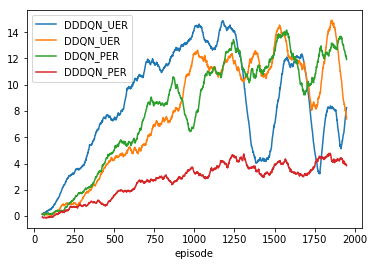

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

import glob
import pandas as pd

#df = [pd.read_csv(f, index_col='episode') for f in glob.glob('results/*scores.csv')]
df = pd.concat([pd.read_csv(f) for f in glob.glob('results/*_scores.csv')], axis=1)
df = df.loc[:,~df.columns.duplicated()]

dfRolling = df.rolling(100).mean()
dfRolling.plot(x='episode', y=['DDDQN_UER', 'DDQN_UER', 'DDQN_PER', 'DDDQN_PER'], kind='line')

I admit each of the experiments were not tuned, so I don't know whether any of those reflect on the true performance and robustness of a solution. Yet, the Dueling Double Deep Q-Learning agent with uniform experience replay was the fastest learner and achieved the highest scores. It did deteriorate in subsequent episodes though, which I did not inspect further. As for the prioritized experience replay, it did not outperform the simpler uniform approach, but again this could be due to the $\alpha$ and $\beta$ schedules which were not tuned.

When finished, you can close the environment.

In [16]:
env.close()

## 5. Policy-based Methods and Experiments

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline

import pandas as pd

from rl.policy.agent import Agent
from rl.policy.cem import cem
from rl.utils.policy import EpsilonGreedy

params = {
    'name': 'CEM',               # Name of the experiment
    'environment': env,          # The environment object
    'brain_name': brain_name,    # The brain name for the unity environment
    'episodes': 2000,            # number of episodes
    'max_t': 5000,               # maximum length of an episode
    'policy': EpsilonGreedy,
    'policy_params': {
        'eps_start': 0.01,       # starting value for the epsilon-greedy action selection
        'eps_end': 0.01,         # end value for the epsilon-greedy action selection
        'eps_decay': 1.          # decay rate for the epsilon-greedy action selection
    },
    'agent_params': {
        'gamma': 0.99,               # discount factor
        'network_params': {
            'state_size': state_size,    # size of the state space
            'action_size': action_size,  # size of the action space
            'hidden_layers': [128, 64],  # hidden layer neurons
        },
    },
    'cross_entropy_params': {
        'pop_size': 50,
        'elite_frac': 0.2,
        'sigma': 0.5
    },
    'maxlen': 100,               # sliding window size of recent scores
    'brain_name': brain_name     # the brain name of the unity environment
}

agent = Agent(params=params)
scores = cem(agent=agent, params=params)

df = pd.DataFrame(data={'episode': np.arange(len(scores)), params['name']: scores})
df.to_csv('results/' + params['name'] + '_scores.csv', index=False)

DEBUG:matplotlib.pyplot:Loaded backend module://ipykernel.pylab.backend_inline version unknown.
DEBUG:rl.policy.agent:Parameter: {'name': 'CEM', 'environment': <unityagents.environment.UnityEnvironment object at 0x105ca9400>, 'brain_name': 'BananaBrain', 'episodes': 2000, 'max_t': 5000, 'policy': <class 'rl.utils.policy.EpsilonGreedy'>, 'policy_params': {'eps_start': 0.01, 'eps_end': 0.01, 'eps_decay': 1.0}, 'agent_params': {'gamma': 0.99, 'network_params': {'state_size': 37, 'action_size': 4, 'hidden_layers': [128, 64]}}, 'cross_entropy_params': {'pop_size': 50, 'elite_frac': 0.2, 'sigma': 0.5}, 'maxlen': 100}
DEBUG:rl.utils.policy:Parameter: {'eps_start': 0.01, 'eps_end': 0.01, 'eps_decay': 1.0}


Episode 100	Average Score: 0.88
Episode 200	Average Score: 3.05
Episode 300	Average Score: 3.39
Episode 400	Average Score: 3.36
Episode 500	Average Score: 3.27
Episode 600	Average Score: 3.42
Episode 700	Average Score: 3.65
Episode 800	Average Score: 3.62
Episode 900	Average Score: 3.76
Episode 937	Average Score: 3.62

KeyboardInterrupt: 

## 6. Future Work

There are a couple of things, I'd consider for future work. From a software engineering perspective, I'd be looking to generalize the configuration further to cover network architecture. At the moment the architecture is hard-coded, which does not invite to any hyperparameter tuning. Additionally, the network architecture could be extended to work with the pixels of the environment rather than a derived state representation. This would be more akin to the work on reaching super-human performance in Atari games lead by several researchers. The agent implementations could be further extended to on-policy approaches, such as SARSA. State of the art performance has been reached since with an agent that combines a number of different approaches into a rainbow implementation [Hessel et al.](https://arxiv.org/abs/1710.02298).

However, before considering any of these extensions, I'd prioritize a more rigorous experimental setup with a proper experimental design and hyperparameter tuning to find the best achieving agent.